## Subject-wise Uncertainty Analysis on RNAseq data
### Authors: D. Tolosa, P. Joshi, R. Banda, B. Ziemann

The objective of the notebook is to compute the subject-based uncertainty of the classifier <br>
The main output from this notebook is the box plot of classifier uncertainty or standard deviation <br>

**_This project was developed at The Data Mine, Purdue University, in partnership with Molecular Stethoscope._**

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Reding csv file containing 243 subjects and their raw TPM counts across 1059 genes
### Source of data
myDF = pd.read_excel("/anvil/projects/tdm/corporate/molecular-stethoscope/data-s23/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name = 1)
# setting index row name to the gene id
myDF = myDF.set_index('gene_id')
# Loading sheet 0, which contains the clinical diagnoses
pathos = pd.read_excel("/anvil/projects/tdm/corporate/molecular-stethoscope/data-s23/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name = 0)
pathos = pathos[~pathos.loc[:,'Isolate ID'].isna()]
pathos = pathos.astype({'Isolate ID':'int'})

#### Step 1: Data Prep

In [19]:
#Filtering out rows: discarding the ERCC rows, ERCC is a control protocol for validation of RNA sequencing
Patients_df = myDF[~myDF.loc[:,'Coeff'].isnull()]

# We store the coefficients(betas) of the linear classifier in an array.
coefficients = np.nan_to_num(np.array(Patients_df.loc[:, "Coeff"]))

# Filtering out columns with patient data
Patients_df = Patients_df.filter(regex='^\d+')

In [20]:
# group columns by patient id
grouped_cols = Patients_df.columns.str.split('-').str[0]

# group columns by patient id and r1/r2 suffixes
grouped = Patients_df.groupby(grouped_cols, axis=1)

# apply the mean function to the r1 and r2 columns for each group
# taking mean of the replicates for subjects with multiple replicates
Patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
# Patients_df.head()

#### Step 2: Computing Zscores from TPM data

In [21]:
Patients_df['Mean']= Patients_df.mean(axis=1)
Patients_df['Std']=Patients_df.iloc[:,:-1].std(axis=1)
#Patients_df.head()

In [22]:
# We define a function whose input is TPM and outputs the corresponding Zscore
def z_score(x):
    return (x-x['Mean'])/x['Std']

In [23]:
# Computing and storing zscores
Patients_df_zScore = Patients_df.apply(lambda x: z_score(x), axis=1)
Patients_df_zScore = Patients_df_zScore.filter(regex='^\d+')

#### Step 3: Defining Monte carlo simulation and classifier functions

In [24]:
# Sampling function performing the Monte Carlo simulations
def Simulation(means, std, coefficients):
    return np.sum(np.multiply(coefficients, np.random.normal(means, std, size=(1, len(coefficients)))))

# Function to perform anti-logit operation on the linear score 
def cl_score(linear_score, gamma = 0):
    temp = gamma + linear_score
    classifier_score = np.exp(temp) / (1 + np.exp(temp))
    return classifier_score

# Function to calculate subject wise mean and std of simulated scores 
def run_sim_one_patient_mean_sd(col,percent,num_runs):
    std = [percent/100 * val for val in col]
    std = np.abs(std)
    temp_Sim = [cl_score(Simulation(col, std, coefficients)) for _ in range(num_runs)]
    return [np.mean(temp_Sim),np.std(temp_Sim)]

# Function to calculate the classifier score for each simulation of "num_runs" simulations, corresponding to each subject
def run_sim_one_patient(col, percent, num_runs):
    std = [percent/100 * val for val in col]
    std = np.abs(std)
    temp_Sim = np.asarray([cl_score(Simulation(col, std, coefficients)) for _ in range(num_runs)])
    return temp_Sim

# This score is the classifer linear score we want to compare with the simulated scores
def linear_score(coefficients, col):
    linear_score = np.sum(coefficients * col, axis=0)
    return linear_score

#### Step 4: [Hyperparameters] We decide on number of simulations per subject (num_runs) assumed variation on TPM counts (uncertainty)
##### num_runs is the number of scores we will generate per patient, each score is generated by choosing a TPM value from a normal distribution that has the actual value as mean (or the average of the TPM counts if there are replicates) and std deviation determined by the variable 'uncertainty'.

In [53]:
num_runs = 10000
RSD = 50 # % relative standard deviation

#### Step 5: Computing subject based uncertainty using Zscores

In [54]:
#Calculating  Subject wise mean and std of simulated scores 
subj_uncertainty = Patients_df_zScore.apply(lambda col: pd.Series(run_sim_one_patient_mean_sd(col,RSD,num_runs), index=['mean', 'uncert(SD)']))

In [2]:
# uncomment the line below for saving as .csv

# subj_uncertainty.to_csv('data/sub-wise_uncert_' + str(RSD) + 'perc_RSD.csv')

#### Step 6: We create a boxplot for visualization of subject-wise uncertainty at the assumed %RDS, and also boxplots for AD and NCI independently

In [55]:
subj_uncert_and_pathos = subj_uncertainty.transpose()
subj_uncert_and_pathos['index1'] = subj_uncert_and_pathos.index
subj_uncert_and_pathos = subj_uncert_and_pathos.astype({'index1':'int'})
subj_uncert_and_pathos = pd.merge(pathos, subj_uncert_and_pathos, left_on='Isolate ID', right_on='index1')
subj_uncert_and_pathos = subj_uncert_and_pathos.drop(['index1'], axis=1)

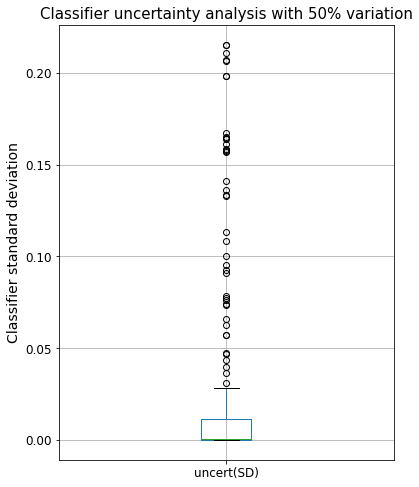

In [56]:
import matplotlib.pyplot as plt

# Plot box plot of uncert column
subj_uncert_and_pathos.boxplot(column=['uncert(SD)'], figsize= (6,8),fontsize= 12)
plt.title('Classifier uncertainty analysis with ' + str(RSD) + '% variation',fontsize= 15)
plt.ylabel('Classifier standard deviation',fontsize= 14)
plt.show()
# uncomment below  and comment above to save
# plt.savefig('box_'+str(RSD)+'perc_RSD.png')

### Below we show the same data, together with independent boxplots for AD and NCI, respectively.

In [63]:
# There is a subject who has no clinical diagnosis, uncomment the line below and run the cell to ignore this patient for the plots.
subj_uncert_and_pathos = subj_uncert_and_pathos[subj_uncert_and_pathos['Disease'].isin(['NCI','AD'])]

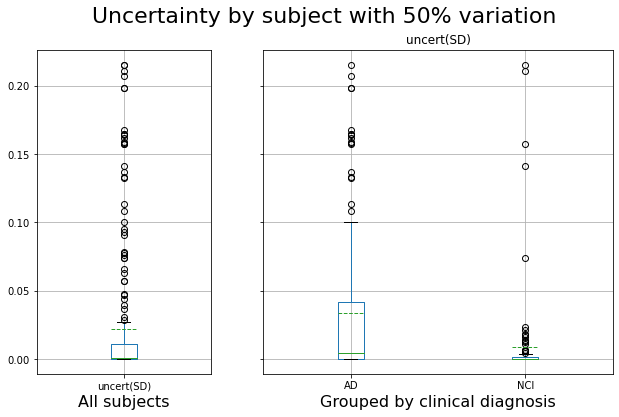

In [64]:
# boxplot for 10% variation
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, sharex = False, sharey = True, squeeze = True,figsize=(10, 6),gridspec_kw={'width_ratios': [1, 2]})
box = subj_uncert_and_pathos.boxplot(column = 'uncert(SD)', by='Disease',meanline=True, showmeans=True, showcaps=True,showbox=True, showfliers=True, ax=axes[1])
subj_uncert_and_pathos.boxplot(column='uncert(SD)',ax=axes[0], meanline = True, showmeans = True)
#plt.tight_layout
#axes[0].set_title('')
axes[0].set_xlabel('All subjects',fontsize=16)
axes[1].set_xlabel('Grouped by clinical diagnosis',fontsize=16)
fig.suptitle('Uncertainty by subject with ' + str(RSD) + '% variation', fontsize=22 , y=1)
#plt.savefig('box_uncert_10.png', bbox_inches='tight')
plt.show()